# Sentiment Analysis

## Overview

## Import Libraries

In [ ]:
!pip install transformers -q

In [ ]:
!pip install nrclex

     |████████████████████████████████| 396 kB 8.7 MB/s 
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43329 sha256=e4d7edb4be24d83b2acc3eb1c898bea1b06c63c5475130ead93ad406c23125c6
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built nrclex


In [ ]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
import seaborn as sns
from wordcloud import wordcloud
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from transformers import pipeline
from nrclex import NRCLex

## Import Data

In [ ]:
## Mount drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
twitter_data = pd.read_csv('/content/drive/MyDrive/Module 3/Datasets/Continent & Country Tweets 2022-03-31.csv')
twitter_data

,screen_name,Source,tweets,time_stamp
0,SelamTsegay1927,Africa,RT @Wedimekelle12: |‘.. A communication blacko...,2022-03-31 08:28:40+00:00
1,brie_ake,Africa,RT @Robelgz: “'Catastrophic' humanitarian cris...,2022-03-31 08:28:40+00:00
2,firdausamo,Africa,RT @mohammedhersi: This was found to TOP prior...,2022-03-31 08:28:40+00:00
3,Tasko_twa,Africa,RT @TimesLIVE: Businessman Malcom X has pledge...,2022-03-31 08:28:40+00:00
4,thefield_in,Africa,#CWC22 #SAvENG\n\nDefending champions #TeamEng...,2022-03-31 08:28:39+00:00
...,...,...,...,...
395,prof_oak123,South Africa,Match was over after first innings. \nNo way s...,2022-03-31 08:26:23+00:00
396,onecrapguy,South Africa,No snow here today I’m pleased to confirm.\n.\...,2022-03-31 08:26:20+00:00
397,karabo80630538,South Africa,"@MmusiMaimane kana ha ore We , ore wena le Man...",2022-03-31 08:26:19+00:00
398,MohamedHamdhoon,South Africa,RT @RYOmoha: In South&amp; North American and ...,2022-03-31 08:26:19+00:00


## Clean Data

In [ ]:
## Rename tweets column to tweet
twitter_data.rename(columns = {'tweets':'tweet'}, inplace = True)

In [ ]:
## clean text

def text_cleaner (text):
  text = re.sub(r'@[A-Za-z0-9]+','',text) ## remove @ mentions
  text = re.sub(r'#','',text) ## remove # symbol
  text = re.sub(r'^RT+','',text) ## remove RT
  text = re.sub(r'https?:\/\/\S+','',text) ## remove hyperlink
  text = re.sub(r'[^\w\s]','',text) ## remove everything apart from words and space
  text = re.sub(r'_',' ',text) ## remove underscore
  text = re.sub(r'\n',' ',text) ## remove \n

  return text


In [ ]:
## Create clean text column

twitter_data['cleaned_tweet'] = twitter_data['tweet'].apply(text_cleaner)
twitter_data = twitter_data[['screen_name','Source','tweet','cleaned_tweet','time_stamp']]
twitter_data

,screen_name,Source,tweet,cleaned_tweet,time_stamp
0,SelamTsegay1927,Africa,RT @Wedimekelle12: |‘.. A communication blacko...,A communication blackout meant Tigray was a...,2022-03-31 08:28:40+00:00
1,brie_ake,Africa,RT @Robelgz: “'Catastrophic' humanitarian cris...,Catastrophic humanitarian crisis in Ethiopia...,2022-03-31 08:28:40+00:00
2,firdausamo,Africa,RT @mohammedhersi: This was found to TOP prior...,This was found to TOP priority by our healt...,2022-03-31 08:28:40+00:00
3,Tasko_twa,Africa,RT @TimesLIVE: Businessman Malcom X has pledge...,Businessman Malcom X has pledged half a mill...,2022-03-31 08:28:40+00:00
4,thefield_in,Africa,#CWC22 #SAvENG\n\nDefending champions #TeamEng...,CWC22 SAvENG Defending champions TeamEngland ...,2022-03-31 08:28:39+00:00
...,...,...,...,...,...
395,prof_oak123,South Africa,Match was over after first innings. \nNo way s...,Match was over after first innings No way sou...,2022-03-31 08:26:23+00:00
396,onecrapguy,South Africa,No snow here today I’m pleased to confirm.\n.\...,No snow here today Im pleased to confirm Camp...,2022-03-31 08:26:20+00:00
397,karabo80630538,South Africa,"@MmusiMaimane kana ha ore We , ore wena le Man...",kana ha ore We ore wena le Mang Its not ab...,2022-03-31 08:26:19+00:00
398,MohamedHamdhoon,South Africa,RT @RYOmoha: In South&amp; North American and ...,In Southamp North American and in Asia the s...,2022-03-31 08:26:19+00:00


## Sentiment Analysis

### Get Text Subjectivity

Subjectivity quantifies the amount of personal opinion and factual information contained in the text. Higher subjectivity means that the text contains personal opinion rather than factual information

In [ ]:
## subjectivity fxn

def get_subjectivity (text):

  return TextBlob(text).sentiment.subjectivity

### Get Text Polarity

Determining whether a word, phrase, or document is positive, negative, or neutral.

In [ ]:
## Polarity fxn

def get_polarity (text):

  return TextBlob(text).sentiment.polarity

In [ ]:
## Create subjectivity and polarity columns

twitter_data['subjectivity'] = twitter_data['cleaned_tweet'].apply(get_subjectivity)

twitter_data['polarity'] = twitter_data['cleaned_tweet'].apply(get_polarity)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## EDA

In [ ]:
## Filter for necessary columns
clean_data = twitter_data[['cleaned_tweet','subjectivity','polarity']]
clean_data['sentiment_class'] = np.where(clean_data['polarity'] > 0, 'positive', 
         (np.where(clean_data['polarity'] < 0, 'negative', 'neutral')))
                                        
clean_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,cleaned_tweet,subjectivity,polarity,sentiment_class
0,A communication blackout meant Tigray was a...,0.000000,0.000000,neutral
1,Catastrophic humanitarian crisis in Ethiopia...,0.600000,0.025000,positive
2,This was found to TOP priority by our healt...,0.537500,0.275000,positive
3,Businessman Malcom X has pledged half a mill...,0.166667,-0.166667,negative
4,CWC22 SAvENG Defending champions TeamEngland ...,0.666667,0.666667,positive


In [ ]:
## Distribution of polarity and subjectivity

clean_data[['subjectivity','polarity']].describe()

,subjectivity,polarity
count,400.000000,400.000000
mean,0.334008,0.078300
std,0.313364,0.275848
min,0.000000,-1.000000
25%,0.000000,0.000000
50%,0.360000,0.000000
75%,0.537500,0.169697
max,1.000000,1.000000


In [ ]:
clean_data['sentiment_class'].value_counts(normalize=True)

neutral     0.4425
positive    0.3550
negative    0.2025
Name: sentiment_class, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


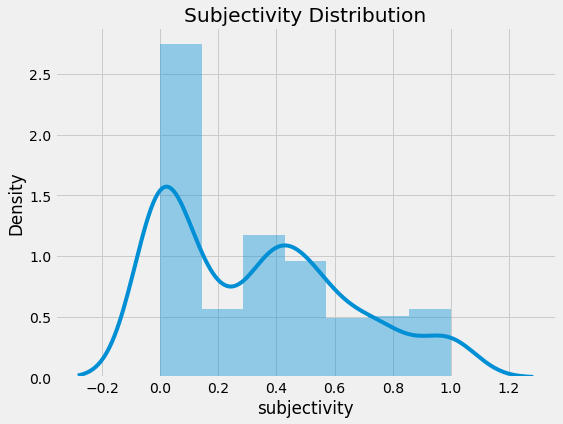

In [ ]:

#sns.scatterplot(data = clean_data, x = range(0,clean_data.shape[0]), y = "subjectivity")
plt.figure(figsize=(8,6))
plt.title('Subjectivity Distribution')
sns.distplot(clean_data['subjectivity'])
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


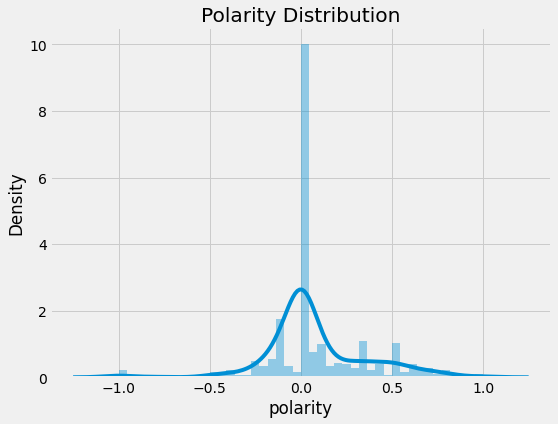

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Polarity Distribution')
sns.distplot(clean_data['polarity'])
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


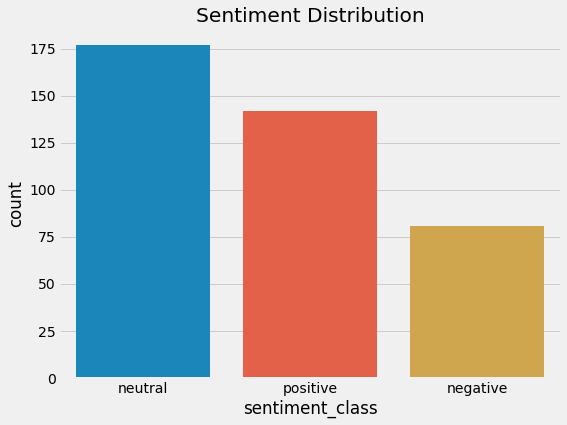

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Sentiment Distribution')
sns.countplot(clean_data['sentiment_class'])
plt.show()

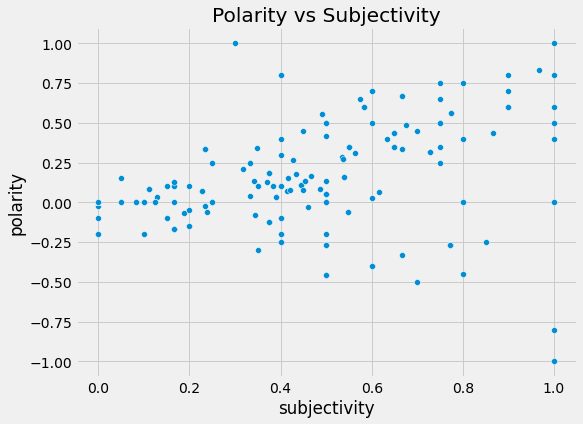

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Polarity vs Subjectivity')
sns.scatterplot(data= clean_data,x="subjectivity",y="polarity")
plt.show()

### Wordclouds

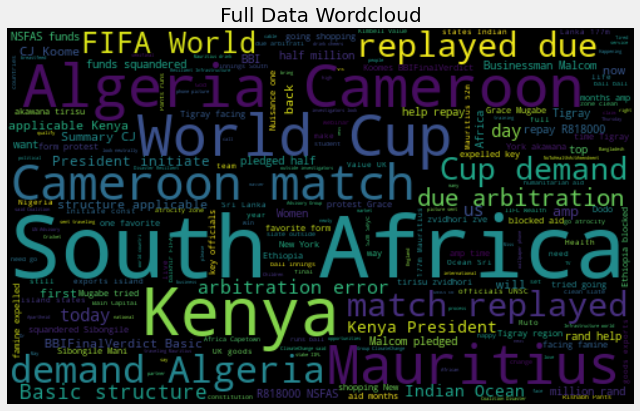

In [ ]:
## Whole Dataset
## Plot word cloud

all_words = ' '.join(twts for twts in clean_data['cleaned_tweet'])

text_cloud = wordcloud.WordCloud(height=300,width=500,random_state=10,max_font_size=110).generate(all_words)

plt.figure(figsize=(10,8))
plt.title('Full Data Wordcloud')
plt.imshow(text_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

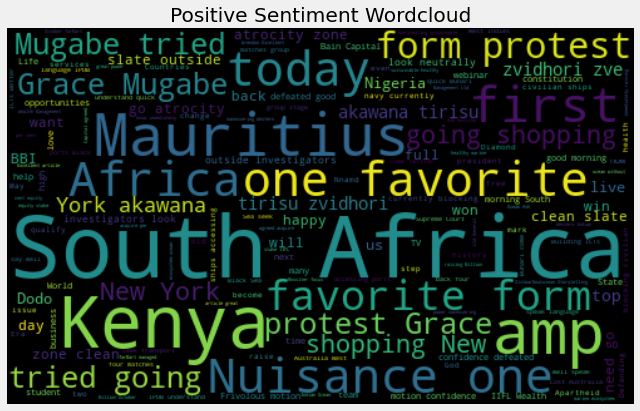

In [ ]:
## Positive polarity
positive_data = clean_data[clean_data['sentiment_class']=='positive']
all_words = ' '.join(twts for twts in positive_data['cleaned_tweet'])

text_cloud = wordcloud.WordCloud(height=300,width=500,random_state=10,max_font_size=110).generate(all_words)

plt.figure(figsize=(10,8))
plt.title('Positive Sentiment Wordcloud')
plt.imshow(text_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

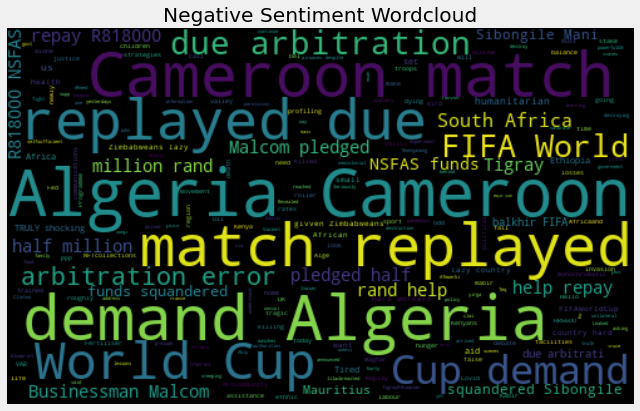

In [ ]:
## Negative polarity
negative_data = clean_data[clean_data['sentiment_class']=='negative']
all_words = ' '.join(twts for twts in negative_data['cleaned_tweet'])

text_cloud = wordcloud.WordCloud(height=300,width=500,random_state=10,max_font_size=110).generate(all_words)

plt.figure(figsize=(10,8))
plt.title('Negative Sentiment Wordcloud')
plt.imshow(text_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Emotion Analysis

Text Emotion Detection using Hugging Face Model Hub's EmoRoberta. EmoRoberta leverages Roberta to perform Emotion classification into 28 categories of Emotion.

In [ ]:
## Define task and model

emotion = pipeline('sentiment-analysis',model='arpanghoshal/EmoRoBERTa')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [ ]:
## Test emotion fxn
clean_data['cleaned_tweet'][:10].apply(emotion)

0    [{'label': 'neutral', 'score': 0.9977561831474...
1     [{'label': 'fear', 'score': 0.9449264407157898}]
2    [{'label': 'neutral', 'score': 0.8901180624961...
3    [{'label': 'neutral', 'score': 0.4156859815120...
4    [{'label': 'neutral', 'score': 0.7470627427101...
5    [{'label': 'neutral', 'score': 0.7593860626220...
6    [{'label': 'neutral', 'score': 0.9836494922637...
7    [{'label': 'approval', 'score': 0.527411699295...
8    [{'label': 'neutral', 'score': 0.9981675148010...
9    [{'label': 'neutral', 'score': 0.9899190664291...
Name: cleaned_tweet, dtype: object

In [ ]:
## Define Emotion fxn

def get_emotion_label (text):

  return (emotion(text)[0]['label'])

def get_emotion_score (text):

  return (emotion(text)[0]['score'])


In [ ]:
%%time
clean_data['emotion_label'] = clean_data['cleaned_tweet'].apply(get_emotion_label)
clean_data['emotion_score'] = clean_data['cleaned_tweet'].apply(get_emotion_score)
clean_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


CPU times: user 5min 27s, sys: 10.7 s, total: 5min 37s
Wall time: 4min 20s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


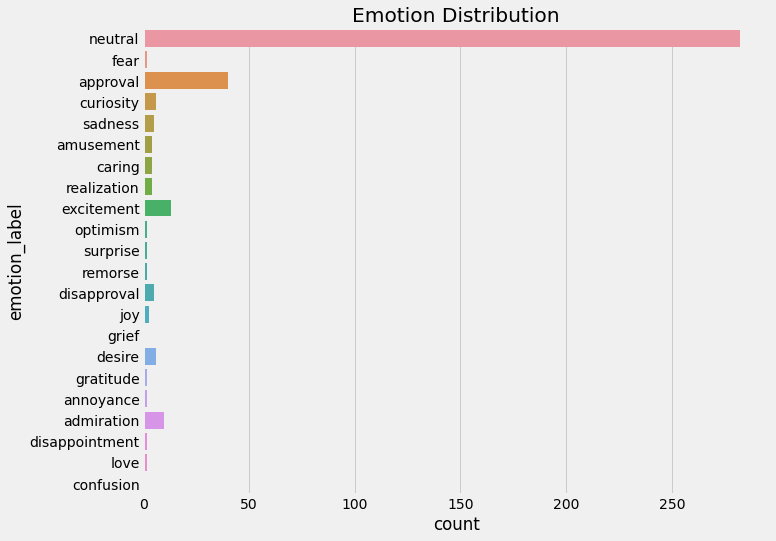

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Emotion Distribution')
sns.countplot(data=clean_data,y='emotion_label')
plt.show()

In [ ]:
clean_data['emotion_label'].value_counts()

neutral           282
approval           40
excitement         13
admiration         10
curiosity           6
desire              6
sadness             5
disapproval         5
amusement           4
caring              4
realization         4
joy                 3
gratitude           2
love                2
disappointment      2
annoyance           2
remorse             2
fear                2
surprise            2
optimism            2
grief               1
confusion           1
Name: emotion_label, dtype: int64

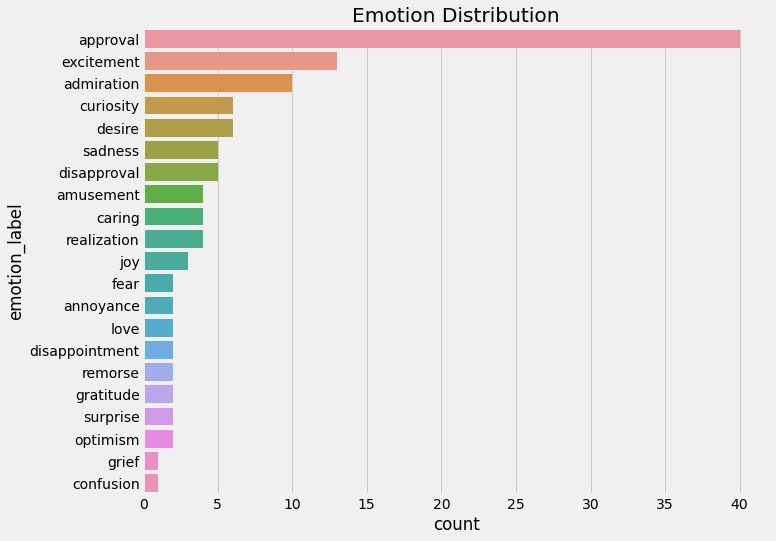

In [ ]:
## Take out dominating neutral
clean_data_neutraless = clean_data[~clean_data['emotion_label'].isin(['neutral'])]

descending_order = clean_data_neutraless['emotion_label'].value_counts().sort_values(ascending=False).index

plt.figure(figsize=(10,8))
plt.title('Emotion Distribution')
sns.countplot(data=clean_data_neutraless,y='emotion_label',order=descending_order)
plt.show()

### NRC Lexicon

In [ ]:
clean_data['emotions'] = clean_data['cleaned_tweet'].apply(lambda x : NRCLex(x).affect_frequencies)
#clean_data.head()

In [ ]:
emotions_data = pd.concat([clean_data.drop(['emotions'],axis=1),clean_data['emotions'].apply(pd.Series)],axis=1)
#emotions_data.head()

In [ ]:
emotions_data.loc[:,'fear':].fillna(0).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fear,400.0,0.038022,0.112908,0.0,0.0,0.0,0.000000,1.0
anger,400.0,0.059452,0.145874,0.0,0.0,0.0,0.000000,1.0
anticip,400.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
trust,400.0,0.099088,0.181420,0.0,0.0,0.0,0.166667,1.0
surprise,400.0,0.028998,0.114238,0.0,0.0,0.0,0.000000,1.0
positive,400.0,0.210284,0.295934,0.0,0.0,0.0,0.333333,1.0
negative,400.0,0.123559,0.214564,0.0,0.0,0.0,0.229167,1.0
sadness,400.0,0.042691,0.111867,0.0,0.0,0.0,0.000000,1.0
disgust,400.0,0.009594,0.037535,0.0,0.0,0.0,0.000000,0.2
joy,400.0,0.046574,0.100249,0.0,0.0,0.0,0.000000,0.5
